Construction d'une base de donnée systeme de controle reorganiser sous forme d'image 3 canaux (a,t,t+1) pour l'adapter au algorithme génératif de diffusion

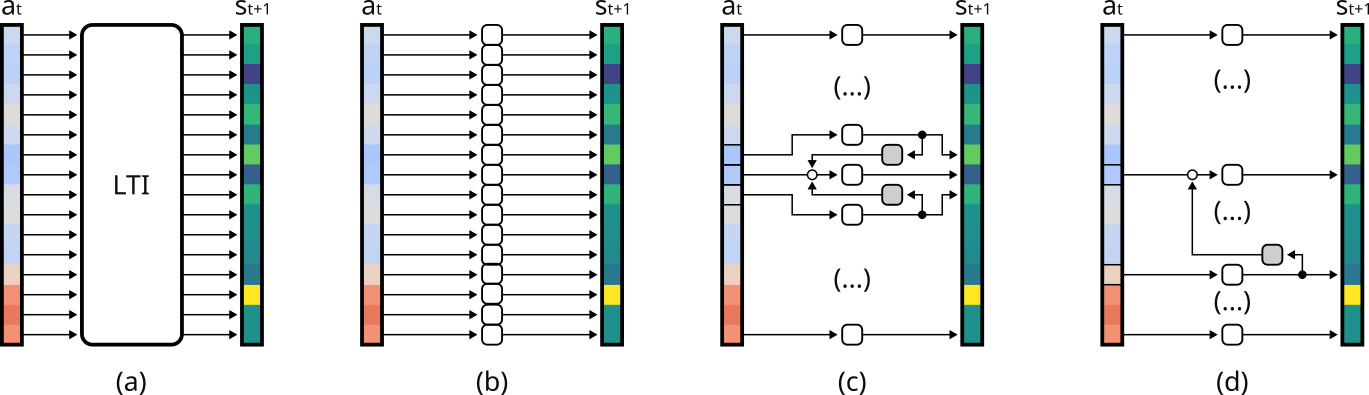

In [ ]:
!pip install diffusers[training] --quiet
!pip install datasets --quiet

In [ ]:
import numpy as np, pylab as plt

from tqdm import tqdm, auto
from pathlib import Path
import os, pandas as pd

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
#from datasets import load_dataset
from dataclasses import dataclass

from accelerate import Accelerator, notebook_launcher

In [ ]:
# setting device on GPU if available, else CPU --> for not ban
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/Colab Notebooks/SetpointReinforcementLearning/DATA/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## SPDL Training configuration

In [ ]:
@dataclass
class TrainingConfig:
    image_size = 32  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 10 # 5
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = dirpath+"ddpm-spdl-32"  # the model name locally and on the HF Hub

    #push_to_hub = True  # whether to upload the saved model to the HF Hub
    #hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

## SPDL Database Load


https://huggingface.co/docs/datasets/v2.18.0/loading

https://huggingface.co/docs/datasets/v1.2.1/loading_datasets.html

https://huggingface.co/docs/datasets/v2.18.0/en/package_reference/loading_methods#datasets.load_dataset

https://huggingface.co/docs/datasets/create_dataset

Utiliser la forme numpy torch : https://discuss.pytorch.org/t/is-numpy-array-a-dataset/47376/2

et pour un dataset avec metadata : https://discuss.pytorch.org/t/how-to-add-meta-features-so-that-i-can-access-them-during-training/115407

In [ ]:
"""
# correction of metadata file
df = pd.read_csv(dirpath + "datafolder/metadata.csv")
df["file_name"] = df["sample_path"].str.split('/', expand=True).iloc[:,-1] + ".npy"
df = df.drop('sample_path', axis=1)
df.to_csv(dirpath + "datafolder/metadata.csv", index=False)
"""

'\n# correction of metadata file\ndf = pd.read_csv(dirpath + "datafolder/metadata.csv")\ndf["file_name"] = df["sample_path"].str.split(\'/\', expand=True).iloc[:,-1] + ".npy"\ndf = df.drop(\'sample_path\', axis=1)\ndf.to_csv(dirpath + "datafolder/metadata.csv", index=False)\n'

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, datapath, csv_file, train_file='train.zip'):
        self.metadata = pd.read_csv(datapath + csv_file)
        self.metadata["p_action"] = self.metadata["p_action"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        self.metadata["p_state"] = self.metadata["p_state"].str.replace("  ",",").str.replace(",,",",").apply(eval)
        # # setting device on GPU if available, else CPU --> for not ban
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # import data & transform
        self.data = []
        all_data_zip = np.load(datapath + train_file) # 100 more faster !
        preprocess = transforms.Compose([transforms.Normalize([0.5], [0.5]),])
        for (i,row) in tqdm(self.metadata.iterrows(), total=self.metadata.shape[0]) :
          data = all_data_zip[row["file_name"]].astype(float)
          # scaling (channel)
          s, a = row['p_state'], row['p_action']
          data[[0,2,4]] = (data[[0,2,4]]/255)*(s[1]-s[0]) + s[0]
          data[[1,3]] = (data[[1,3]]/255)*(a[1]-a[0]) + a[0]
          # normalize (all channel)
          data = (data - data.min()) / (data.max() - data.min())
          # convert & standardize
          data = torch.tensor(data, dtype=torch.float).to(device)
          self.data += [preprocess(data)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx] # change to iterableDataset to add pandas info

In [ ]:
csv_file = 'metadata.csv'
data = CustomDataset(dirpath + "datafolder_train/", csv_file)

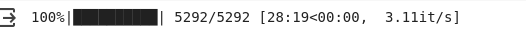

In [ ]:
train_dataloader = DataLoader(data, batch_size=config.train_batch_size, shuffle=True)
sample = train_dataloader.dataset[0][None]
sample.shape

torch.Size([1, 5, 32, 32])

In [ ]:
for step, batch in enumerate(train_dataloader):
  pass
print(batch.min(), batch.max(), batch.mean())

tensor(-1., device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0078, device='cuda:0')


## Create UnetDiffuser

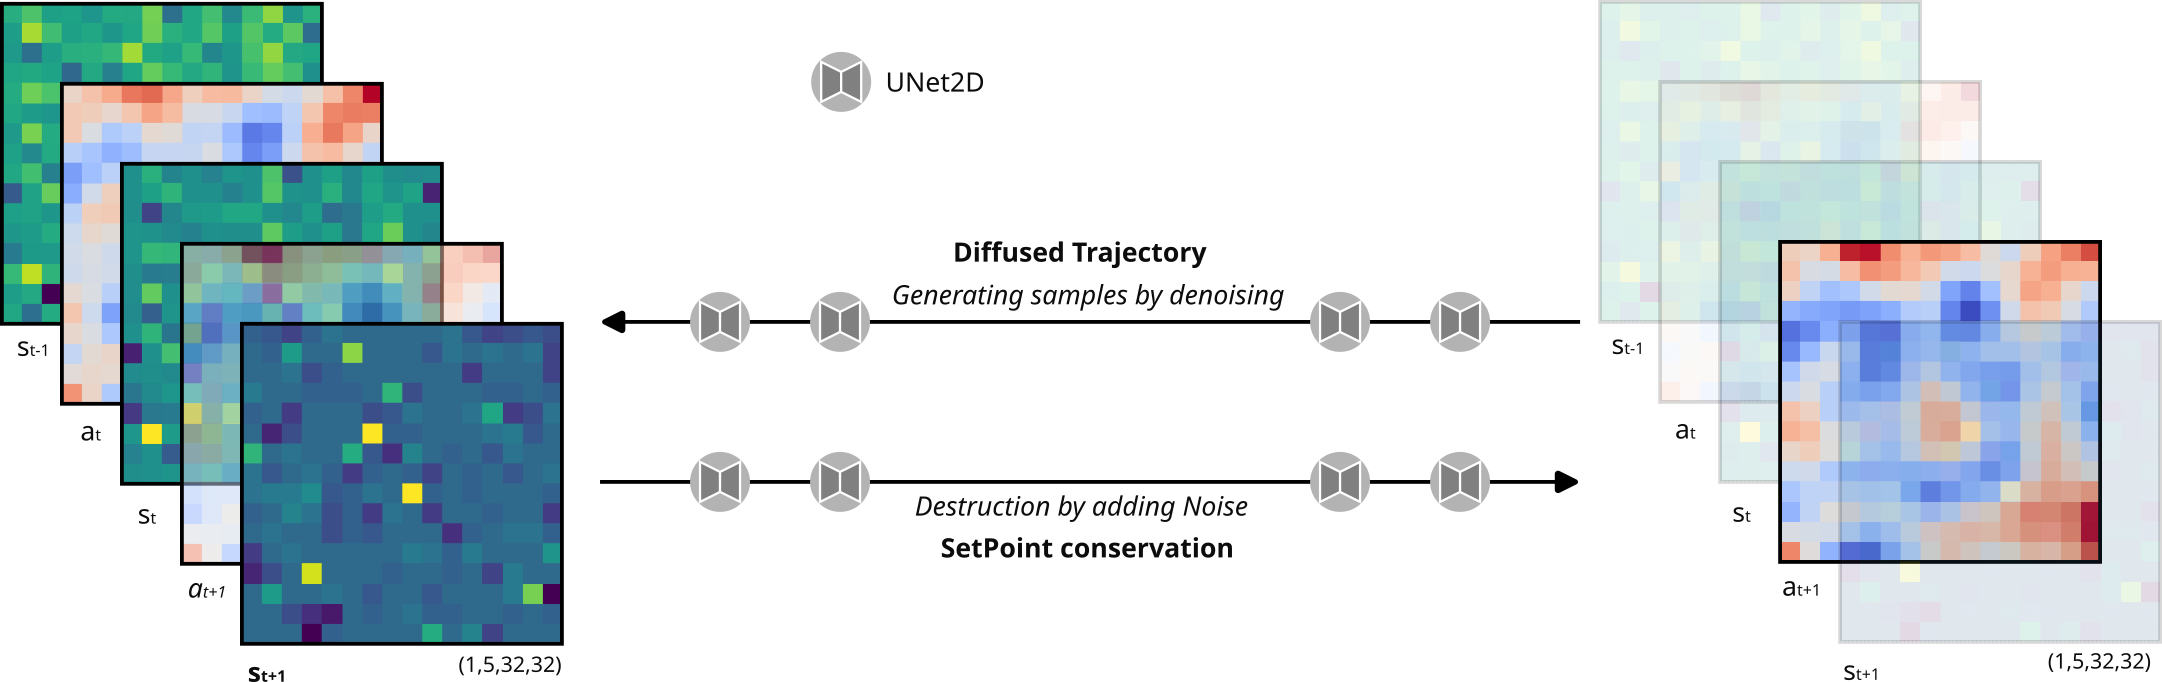

https://huggingface.co/docs/diffusers/tutorials/basic_training

https://github.com/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

Pour la derniere couche, on a un Squeeze https://arxiv.org/pdf/1709.01507.pdf

Comme on utilise torch pour le dataset, voir : https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers_doc/en/pytorch/basic_training.ipynb#scrollTo=0BWtDZK1xsR8

In [ ]:
n_channel = 5 #3
size = 32 #128 --> 32 minimum (block convolution) <=> Squeeze-and-Excitation Networks for middle layer

model = UNet2DModel(
    sample_size=size,  # the target image resolution
    in_channels= n_channel,
    out_channels= n_channel,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(size, size, 2*size, 2*size, 4*size, 4*size),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

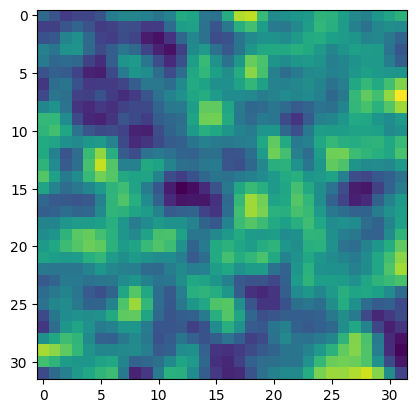

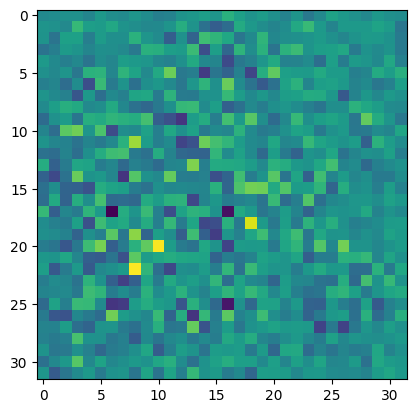

In [ ]:
# test
noise_pred = model(sample.to("cpu"), torch.LongTensor([2]), return_dict=False)[0]
plt.imshow(sample.cpu().detach().numpy()[0,1]); plt.show()
plt.imshow(noise_pred.detach().numpy()[0,1]); plt.show()

## Create a scheduler

Le planificateur se comporte différemment selon que vous utilisez le modèle à des fins de formation ou d'inférence. Lors de l'inférence, le planificateur génère une image à partir du bruit. Pendant la formation, le planificateur prend une sortie de modèle - ou un échantillon - à partir d'un point spécifique du processus de diffusion et applique du bruit à l'image selon un *programme de bruit* et une *règle de mise à jour*.

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

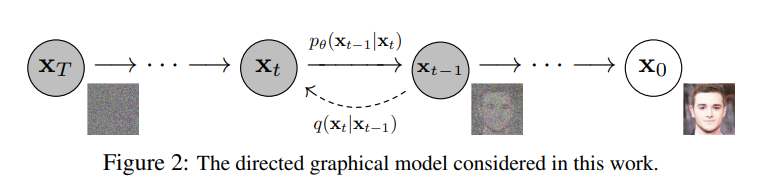

Concretement, l'entrainement correspond à une chaine de markov à un inférence variationnelle à optimiser

In [ ]:
"""
# See the output --> to adapt with 5 channel and without PIL
def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")
"""

'\n# See the output --> to adapt with 5 channel and without PIL\ndef make_grid(images, rows, cols):\n    w, h = images[0].size\n    grid = Image.new("RGB", size=(cols * w, rows * h))\n    for i, image in enumerate(images):\n        grid.paste(image, box=(i % cols * w, i // cols * h))\n    return grid\n\ndef evaluate(config, epoch, pipeline):\n    # Sample some images from random noise (this is the backward diffusion process).\n    # The default pipeline output type is `List[PIL.Image]`\n    images = pipeline(\n        batch_size=config.eval_batch_size,\n        generator=torch.manual_seed(config.seed),\n    ).images\n\n    # Make a grid out of the images\n    image_grid = make_grid(images, rows=4, cols=4)\n\n    # Save the images\n    test_dir = os.path.join(config.output_dir, "samples")\n    os.makedirs(test_dir, exist_ok=True)\n    image_grid.save(f"{test_dir}/{epoch:04d}.png")\n'

## Train model

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, setpoint_approach=False, inverted_setpoint=False):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = auto.tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch #["images"] --> here, is directly in good form
            bs = clean_images.shape[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            if setpoint_approach :
              # Here test our approach with randomly fix an channel not noised
              random_channel_list = np.concatenate((np.arange(bs)[None],np.random.randint(0,5,bs)[None]))
              rdid = list(map(list,random_channel_list))
              if inverted_setpoint :
                unnoise = 5.*clean_images.clone()
                unnoise[rdid[0],rdid[1]] = noise[rdid[0],rdid[1]]
                noise = unnoise
              else :
                noise[rdid[0],rdid[1]] = 5.*clean_images[rdid[0],rdid[1]]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            #if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            #    evaluate(config, epoch, pipeline)
            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir)

In [ ]:
setpoint_approach, inverted_setpoint = True, True
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler, setpoint_approach, inverted_setpoint)

## in GPU is 5-10 faster !
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

  0%|          | 0/331 [00:00<?, ?it/s]

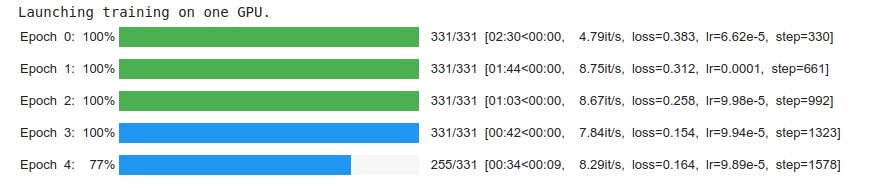

## Test model

In [ ]:
from transformers import AutoConfig, AutoModel

# test model
saved_model = AutoModel.from_pretrained(dirpath+"ddpm-spdl-32")

## Source :


https://www.reddit.com/r/StableDiffusion/comments/1581qjk/making_and_training_stable_diffusion_models_from/?rdt=36200

https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb

https://diffusion-planning.github.io/

https://huggingface.co/docs/diffusers/tutorials/basic_training

Attention : Stable diffusion est different de diffusion, car espace latent : https://arxiv.org/abs/2112.10752 (impossible from scratch, uniquement pretrained https://www.databricks.com/blog/stable-diffusion-2 )

ici, juste un UNet : https://arxiv.org/abs/1505.04597

https://github.com/opendilab/awesome-diffusion-model-in-rl

ici : Unconditional diffusion